# Employee Job Satisfaction Classification based on Answers to Behavioral Questions

This project tackles the problem of understanding whether an employee is satisfied with their job based on responses to behavioral questions. Generally, survey data is confidential and thus cannot be used as a metric to suggest personal recommendations. However, with this analysis, we want to answer the following questions:

* Is it possible to establish a relation between behavioral questions and job satisfaction?
* Can traditional techniques for machine learning such as logistic regression and decision trees yeild suitable results or are advanced techniques such as bagging and boosting required?
* Is feature engineering permissible for two datasets that may or may not be completely or partially exclusive?

To perform these evaluations, the following considerations and assumptions must be made:
1. Accuracy must be used as a metric.
2. Data should be kept as close to original as possible.

## Hypothesis

* Null Hypothesis: Behavioral Questions and an Employee's Attitude play a significant role in job satisfaction, and advanced models such as Neural Networks or ensemble learning perform better to classify this information.

* Alternate Hypothesis 1: Behavioral Questions and an Employee's Attitude play a significant role in job satisfaction, and simple models such as Decision Trees perform better to classify this information.

* Alternate Hypothesis 2: Behavioral Questions and an Employee's Attitude do not play a significant role in job satisfaction.

### Data sources

* [KPMI.ru questionnaire generated data, provided by Stanislav Kovalenko on Kaggle](https://www.kaggle.com/datasets/spookyyolk/fields-of-activity-and-psychological-preferences)

* [Link to KPMI.ru questionnaire](https://kpmi.ru/)

Making connection with the drive to mount data files

In [ ]:
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials



# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
link = "https://drive.google.com/file/d/1sRhZ9dUVywu2okF-4GT3Nt8yuDO-XP7j/view"
id = link.split("/")[-2]

downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('fields_of_activities_predisposition_data.csv')
# Change the dataset file path here to relevant location in your directory

Importing the libraries

In [ ]:
import pandas as pd
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix, classification_report, accuracy_score, f1_score
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from keras.models import Model
from keras.layers import Input, Dense
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import  train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier

# Performing EDA for 'fields_of_activities_predisposition' Dataset



Loading dataset

In [ ]:
df = pd.read_csv('fields_of_activities_predisposition_data.csv')
df.head()

,foa,time,q1,q2,q3,q4,q5,q6,q7,q8,...,q53,q54,q55,q56,q57,q58,q59,q60,q61,q62
0,foa_01,527.90,1,1,1,1,1,2,1,1,...,2,1,2,1,1,2,1,2,2,2
1,foa_01,386.27,2,2,2,1,1,2,1,1,...,2,2,2,1,1,1,1,1,1,1
2,foa_01,281.28,2,1,2,1,2,2,2,1,...,2,1,2,2,2,1,1,1,1,1
3,foa_01,979.34,1,1,2,1,1,1,2,1,...,2,1,1,2,1,1,2,1,1,1
4,foa_01,378.25,2,2,2,2,2,2,1,1,...,2,1,2,1,1,2,1,2,1,1


In [ ]:
print(df.shape)

(84868, 64)


In [ ]:
df.describe()

,time,q1,q2,q3,q4,q5,q6,q7,q8,q9,...,q53,q54,q55,q56,q57,q58,q59,q60,q61,q62
count,8.486800e+04,84868.000000,84868.000000,84868.000000,84868.000000,84868.000000,84868.000000,84868.000000,84868.000000,84868.000000,...,84868.000000,84868.000000,84868.000000,84868.000000,84868.000000,84868.000000,84868.000000,84868.000000,84868.000000,84868.000000
mean,1.105749e+03,1.515825,1.560647,1.319025,1.343215,1.384762,1.605057,1.429844,1.572607,1.516697,...,1.576554,1.291252,1.674271,1.313581,1.331338,1.311743,1.524568,1.394778,1.643977,1.683473
std,1.726448e+04,0.499752,0.496311,0.466101,0.474785,0.486542,0.488841,0.495057,0.494703,0.499724,...,0.494108,0.454342,0.468649,0.463951,0.470697,0.463208,0.499399,0.488806,0.824908,0.775554
min,-7.588400e+04,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,4.228200e+02,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
50%,5.315625e+02,2.000000,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,2.000000,...,2.000000,1.000000,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000
75%,6.830500e+02,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,...,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
max,2.276574e+06,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,...,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,3.000000,3.000000


Checking for null values

In [ ]:
df = df.replace("?", np.NaN)
df.isnull().sum()

foa     0
time    0
q1      0
q2      0
q3      0
       ..
q58     0
q59     0
q60     0
q61     0
q62     0
Length: 64, dtype: int64

Plotting HeatMap

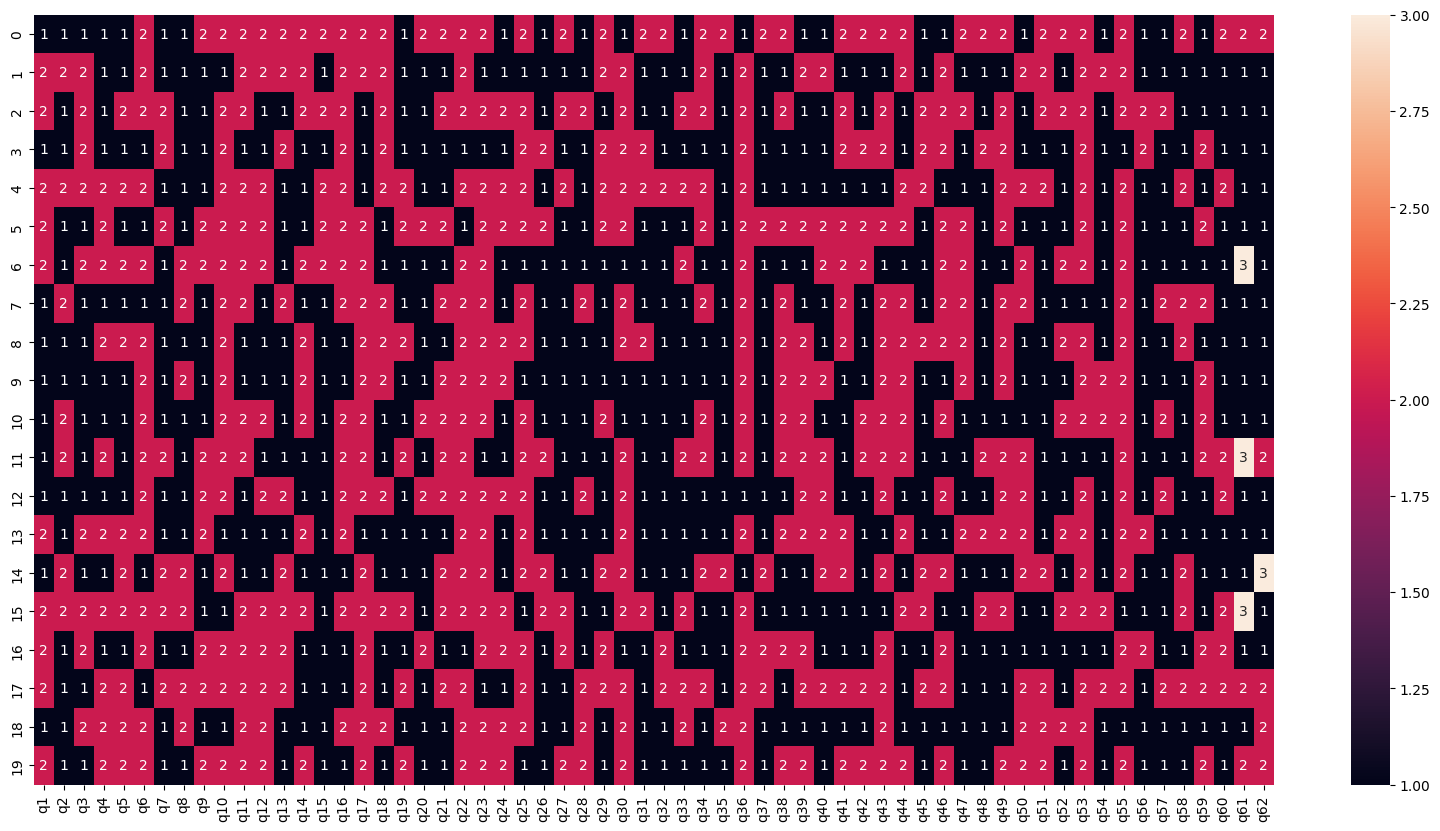

In [ ]:
df_without_foa = df.drop(['foa', 'time'], axis=1)
plt.figure(figsize=(20,10))
heatmap_for_df1_head = sns.heatmap(df_without_foa.iloc[:20,:64], vmin=1, vmax=3, annot=True)
plt.show()

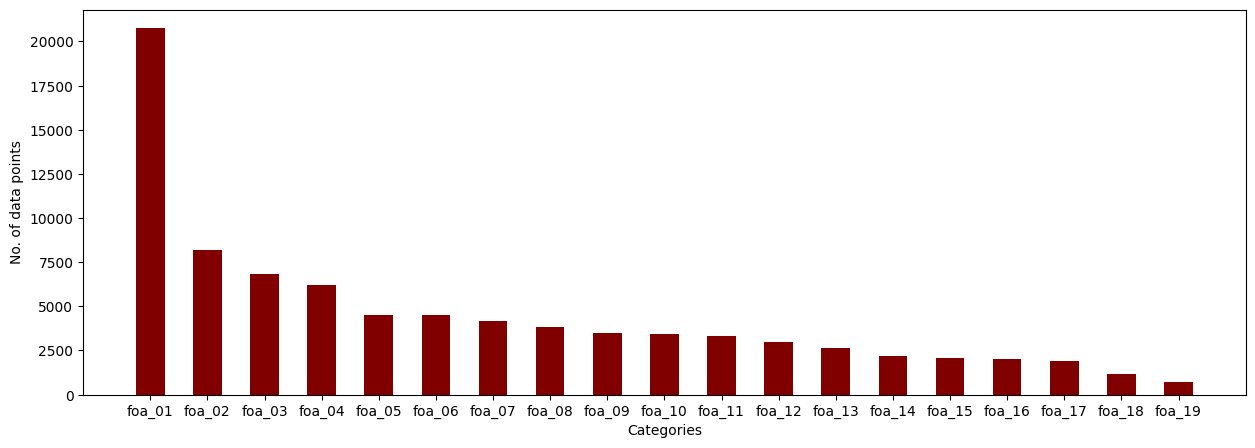

In [ ]:
# plot class labels histogram for df1
fig = plt.figure(figsize = (15, 5))
# creating the bar plot
plt.bar(df['foa'].unique(), df['foa'].value_counts(), color ='maroon', width = 0.5)
plt.xlabel("Categories")
plt.ylabel("No. of data points")
plt.show()

In [ ]:
value_counts_dict = {'Feature': [], 'Value_1_Count': [], 'Value_2_Count': [], 'Value_3_Count': []}

# single graph
# Iterate through each column in the DataFrame
for column in df.columns:
    # Skip columns that are not q1 to q62
    if column.startswith('q'):
        # Count occurrences of values 1, 2, and 3 in the column
        value_counts = df[column].value_counts().to_dict()
        # Append counts to the dictionary
        value_counts_dict['Feature'].append(column)
        value_counts_dict['Value_1_Count'].append(value_counts.get(1, 0))
        value_counts_dict['Value_2_Count'].append(value_counts.get(2, 0))
        value_counts_dict['Value_3_Count'].append(value_counts.get(3, 0))

# Create a new DataFrame from the dictionary
value_counts_df = pd.DataFrame(value_counts_dict, columns=['Feature', 'Value_1_Count', 'Value_2_Count', 'Value_3_Count'])
value_counts_df = value_counts_df.set_index('Feature')
value_counts_df

         Value_1_Count  Value_2_Count  Value_3_Count
Feature                                             
q1               41091          43777              0
q2               37287          47581              0
q3               57793          27075              0
q4               55740          29128              0
q5               52214          32654              0
...                ...            ...            ...
q58              58411          26457              0
q59              40349          44519              0
q60              51364          33504              0
q61              49361          16361          19146
q62              43206          25319          16343

[62 rows x 3 columns]


In [ ]:
percentage_counts_df = value_counts_df.div(len(df)).mul(100)
print(percentage_counts_df)

         Value_1_Count  Value_2_Count  Value_3_Count
Feature                                             
q1           48.417543      51.582457       0.000000
q2           43.935288      56.064712       0.000000
q3           68.097516      31.902484       0.000000
q4           65.678465      34.321535       0.000000
q5           61.523778      38.476222       0.000000
...                ...            ...            ...
q58          68.825706      31.174294       0.000000
q59          47.543244      52.456756       0.000000
q60          60.522223      39.477777       0.000000
q61          58.162087      19.278173      22.559740
q62          50.909648      29.833388      19.256964

[62 rows x 3 columns]


In [ ]:
import plotly.express as px
fig1 = px.line_polar(percentage_counts_df, r=percentage_counts_df["Value_1_Count"].tolist(), theta=percentage_counts_df.index.tolist(), line_close=True)
fig1.update_traces(fill='toself')
fig1.update_layout(
    title=dict(text="Percentage of people who chose the first option", font=dict(size=18), automargin=True, yref='paper')
)
fig1.show()

fig2 = px.line_polar(percentage_counts_df, r=percentage_counts_df["Value_2_Count"].tolist(), theta=percentage_counts_df.index.tolist(), line_close=True)
fig2.update_traces(fill='toself')
fig2.update_layout(
    title=dict(text="Percentage of people who chose the second option", font=dict(size=18), automargin=True, yref='paper')
)
fig2.show()

fig3 = px.line_polar(percentage_counts_df, r=percentage_counts_df["Value_3_Count"].tolist(), theta=percentage_counts_df.index.tolist(), line_close=True)
fig3.update_traces(fill='toself')
fig3.update_layout(
    title=dict(text="Percentage of people who chose the third option", font=dict(size=18), automargin=True, yref='paper')
)
fig3.show()

In [ ]:
# creating train test split for df1
from sklearn.model_selection import  train_test_split
X = df.drop(['foa', 'time', 'q61'], axis=1)
y = df['q61']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=47)

# Models implemented
1. KNN
2. Naive baise
3. Decison tree Cart & C5.0
4. RF
5. SVM
6. ANN (also known as Multilayer Perceptron)
7. Logistic Regression
8. ADA boost
9. Deep Neural Network


# Result Dictionary

In [ ]:
results = []
# def add_to_results(name, Accuracy_Score, F1_Score):
#   results.append({'name': name, 'Accuracy_Score': Accuracy_Score, 'F1_Score': F1_Score})
def add_to_results(name, Accuracy_Score):
  results.append({'name': name, 'Accuracy_Score': Accuracy_Score})

# Decision Tree Classifier C5.0

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import  train_test_split
C5_model = DecisionTreeClassifier(criterion='entropy', splitter='best', max_depth=8, max_leaf_nodes=4)
C5_model.fit(X_train,y_train)
y_pred=C5_model.predict(X_test)

Classification Report: 

              precision    recall  f1-score   support

           1       0.87      0.77      0.82     14762
           2       0.52      0.80      0.63      4995
           3       0.51      0.43      0.47      5704

    accuracy                           0.70     25461
   macro avg       0.63      0.67      0.64     25461
weighted avg       0.72      0.70      0.70     25461


Confusion Matrix:
[[11301  1545  1916]
 [  512  3977   506]
 [ 1113  2118  2473]]

Accuracy: 0.6971839283610227


<Axes: >

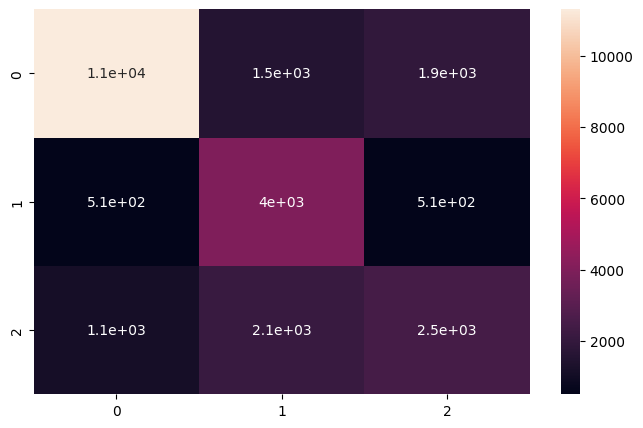

In [ ]:
print("Classification Report: \n")
print(classification_report(y_test, y_pred), end="\n")
print(f'\nConfusion Matrix:\n{confusion_matrix(y_test, y_pred)}')
print(f'\nAccuracy: {accuracy_score(y_test, y_pred)}')
add_to_results('DecisionTree C5.0', accuracy_score(y_test, y_pred));
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (8,5))
sns.heatmap(cm, annot=True)

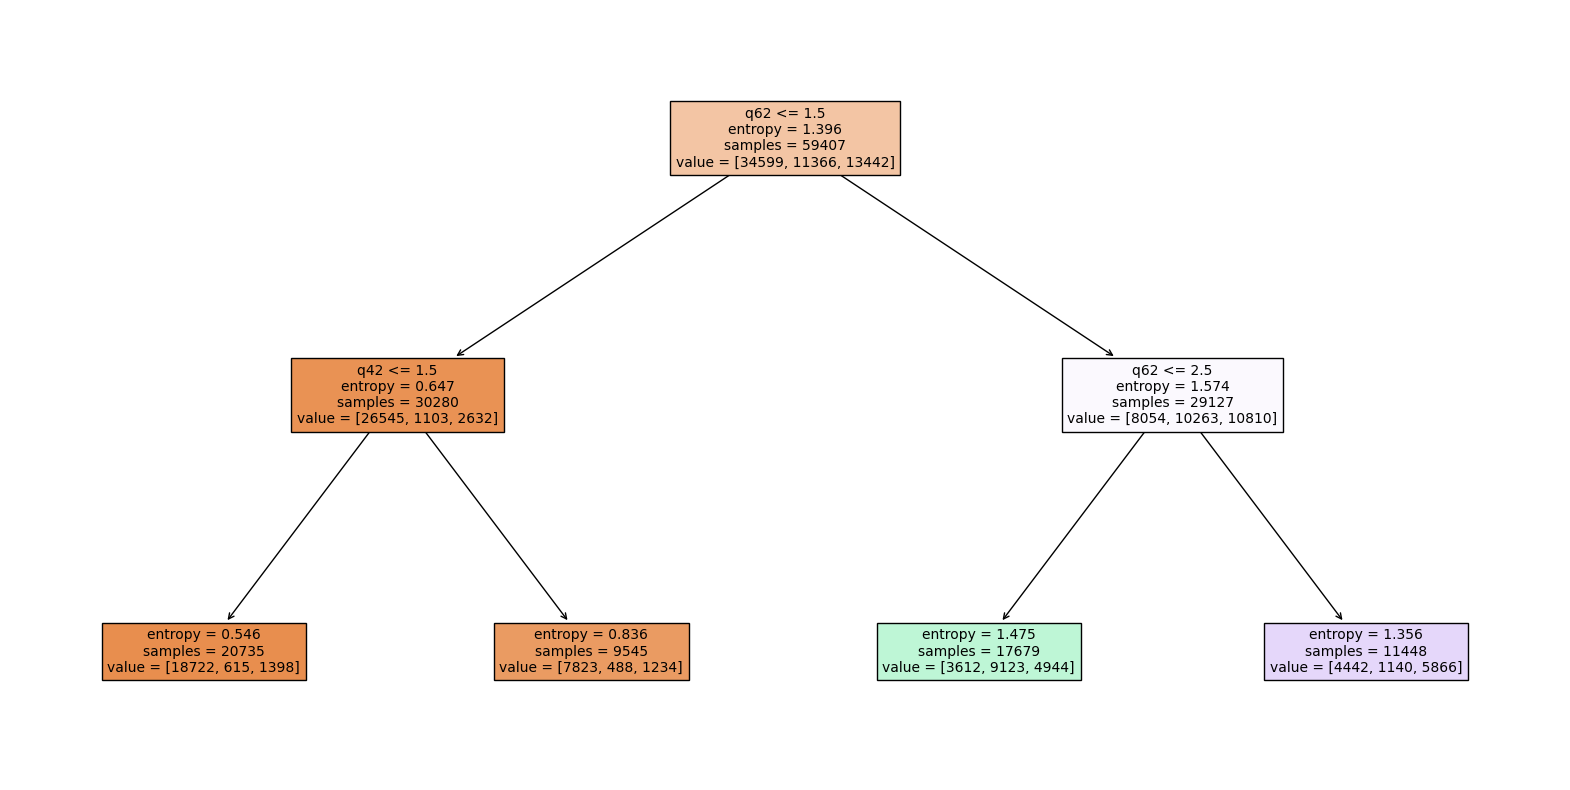

In [ ]:
from sklearn.tree import plot_tree
plt.figure(figsize=(20,10))
plot_tree(C5_model,fontsize=10,filled=True,feature_names=X.columns);

['q42' 'q62']
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.01309697
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.98690303]


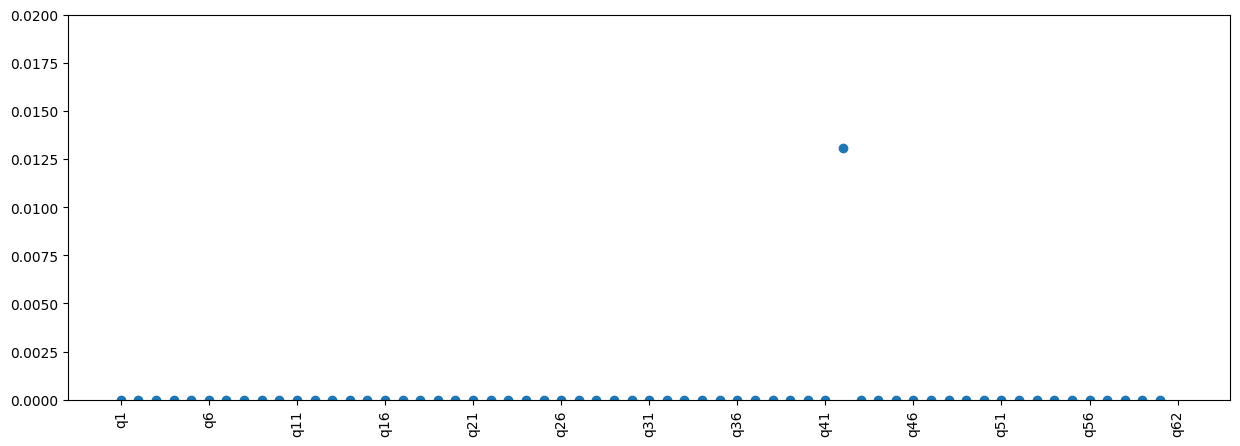

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(C5_model.feature_importances_, 'o')
plt.xticks(range(0, X.shape[1], 5), X.columns[::5], rotation=90)
#plt.plot(C5_model.feature_importances_, 'o')
#plt.xticks(range(X.shape[1]), X.columns, rotation=90)
plt.ylim(0, 0.02)
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': C5_model.feature_importances_})
important_features = feature_importance_df[feature_importance_df['Importance'] > feature_importance_df.describe().loc['75%']['Importance']]
important_features = feature_importance_df[feature_importance_df['Importance'] > feature_importance_df.describe().loc['75%']['Importance']]
print(important_features['Feature'].values)
print(C5_model.feature_importances_)
plt.show()


<ipython-input-20-c55f2b529fd8>:4: UserWarning:

FixedFormatter should only be used together with FixedLocator



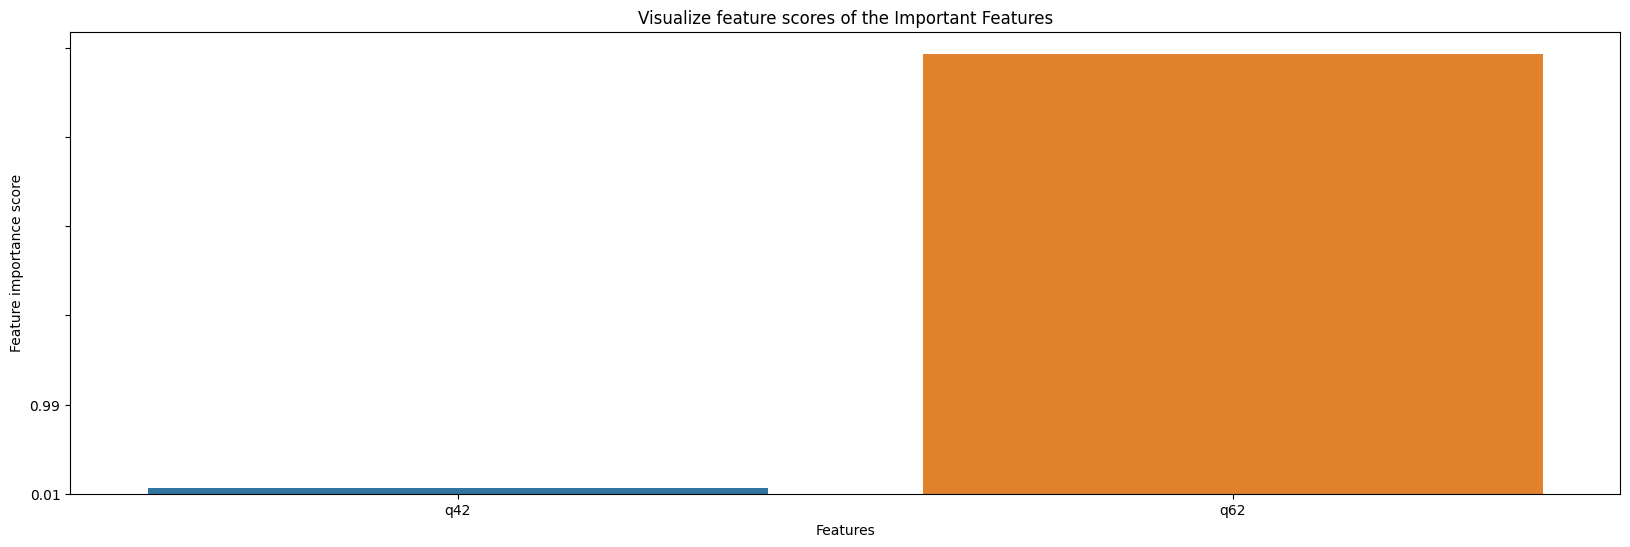

In [ ]:
f, ax = plt.subplots(figsize=(20, 6))
ax = sns.barplot(x=important_features['Feature'], y=important_features['Importance'], data=important_features)
ax.set_title("Visualize feature scores of the Important Features")
ax.set_yticklabels(round(important_features['Importance'], 2))
ax.set_xlabel("Features")
ax.set_ylabel("Feature importance score")
plt.show()

# RF

Classification Report for df1 features: 

              precision    recall  f1-score   support

           1       0.74      0.87      0.80     14762
           2       0.52      0.44      0.47      4995
           3       0.45      0.32      0.37      5704

    accuracy                           0.66     25461
   macro avg       0.57      0.54      0.55     25461
weighted avg       0.63      0.66      0.64     25461


Confusion Matrix:
[[12828   799  1135]
 [ 1748  2183  1064]
 [ 2670  1235  1799]]

Accuracy: 0.6602254428341385


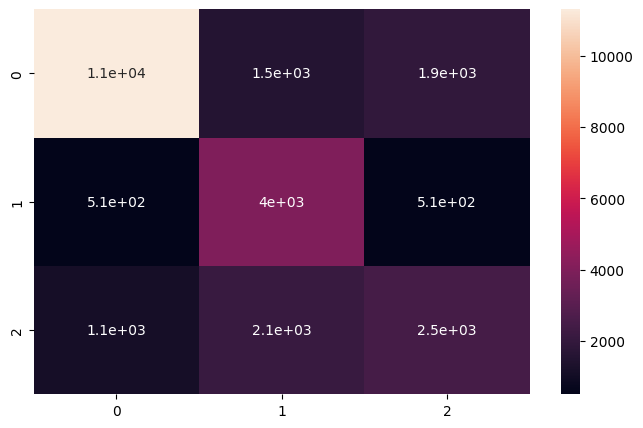

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import  train_test_split
# We create a Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=10, random_state=42)

# Train the Random Forest Classifier
rf_classifier.fit(X_train, y_train)

# Predict using the trained Random Forest Classifier
y_pred_rf = rf_classifier.predict(X_test)

# Print the classification report, confusion matrix, and accuracy
print("Classification Report for df1 features: \n")
print(classification_report(y_test, y_pred_rf), end="\n")
print(f'\nConfusion Matrix:\n{confusion_matrix(y_test, y_pred_rf)}')
print(f'\nAccuracy: {accuracy_score(y_test, y_pred_rf)}')
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (8,5))
sns.heatmap(cm, annot=True)
# add_to_results('Random Forest', accuracy_score(y_test, y_pred), f1_score(y_test, y_pred, average=None))
add_to_results('Random Forest', accuracy_score(y_test, y_pred))

In [ ]:
# view the feature scores
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': rf_classifier.feature_importances_})
important_features = feature_importance_df[feature_importance_df['Importance'] > feature_importance_df.describe().loc['75%']['Importance']]
print(important_features['Feature'].values)

['q7' 'q9' 'q10' 'q12' 'q13' 'q16' 'q19' 'q23' 'q24' 'q29' 'q42' 'q47'
 'q50' 'q53' 'q62']


<ipython-input-23-c55f2b529fd8>:4: UserWarning:

FixedFormatter should only be used together with FixedLocator



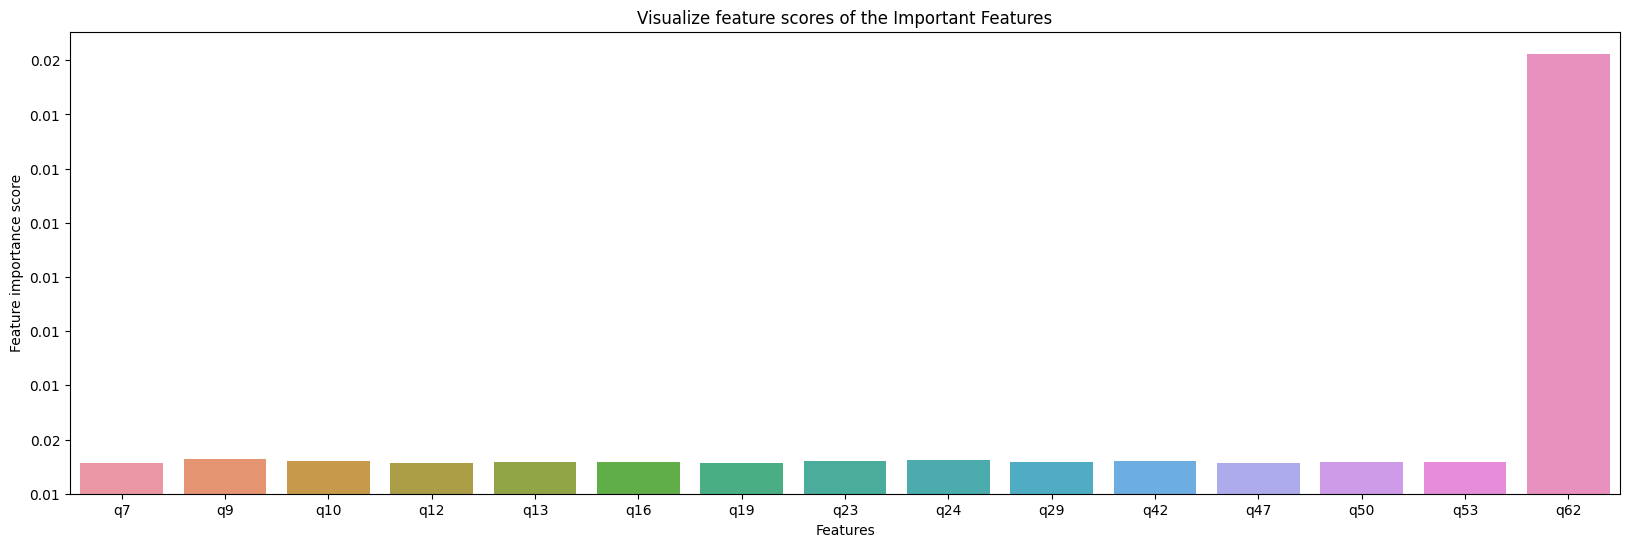

In [ ]:
f, ax = plt.subplots(figsize=(20, 6))
ax = sns.barplot(x=important_features['Feature'], y=important_features['Importance'], data=important_features)
ax.set_title("Visualize feature scores of the Important Features")
ax.set_yticklabels(round(important_features['Importance'], 2))
ax.set_xlabel("Features")
ax.set_ylabel("Feature importance score")
plt.show()

In [ ]:
# Feature importance for Mean Decrease Accuracy
mean_decrease_accuracy = rf_classifier.feature_importances_
print(f"Mean Decrease Accuracy{mean_decrease_accuracy}")

# Feature importance for Mean Decrease GINI
gini_importance = rf_classifier.feature_importances_ * rf_classifier.estimators_[0].tree_.impurity[0]
print(f"\nMean Decrease GINI= {gini_importance}")

Mean Decrease Accuracy[0.01243924 0.01322639 0.01329727 0.01312957 0.01211049 0.01417706
 0.01435401 0.01412909 0.01602    0.01493246 0.01008688 0.01436561
 0.0145227  0.01392387 0.01290729 0.01460114 0.01183831 0.01400164
 0.01430252 0.01358867 0.01255242 0.0129457  0.014963   0.01533439
 0.01321652 0.0127696  0.01193517 0.014173   0.0145604  0.01063985
 0.01076006 0.01100717 0.01285718 0.01389789 0.01245599 0.0119023
 0.01191796 0.01297341 0.01248454 0.01337651 0.01222587 0.01532501
 0.01288025 0.01428597 0.01367017 0.0133042  0.01434386 0.01271486
 0.01396353 0.01480603 0.01359738 0.01344763 0.01456859 0.0112872
 0.01268554 0.01222245 0.01362982 0.01301722 0.01286341 0.01347984
 0.20300391]

Mean Decrease GINI= [0.00712278 0.0075735  0.00761409 0.00751807 0.00693453 0.00811786
 0.00821919 0.0080904  0.00917314 0.00855041 0.0057758  0.00822583
 0.00831578 0.00797289 0.00739079 0.0083607  0.00677868 0.00801742
 0.0081897  0.00778095 0.00718759 0.00741278 0.0085679  0.00878056
 0.00756

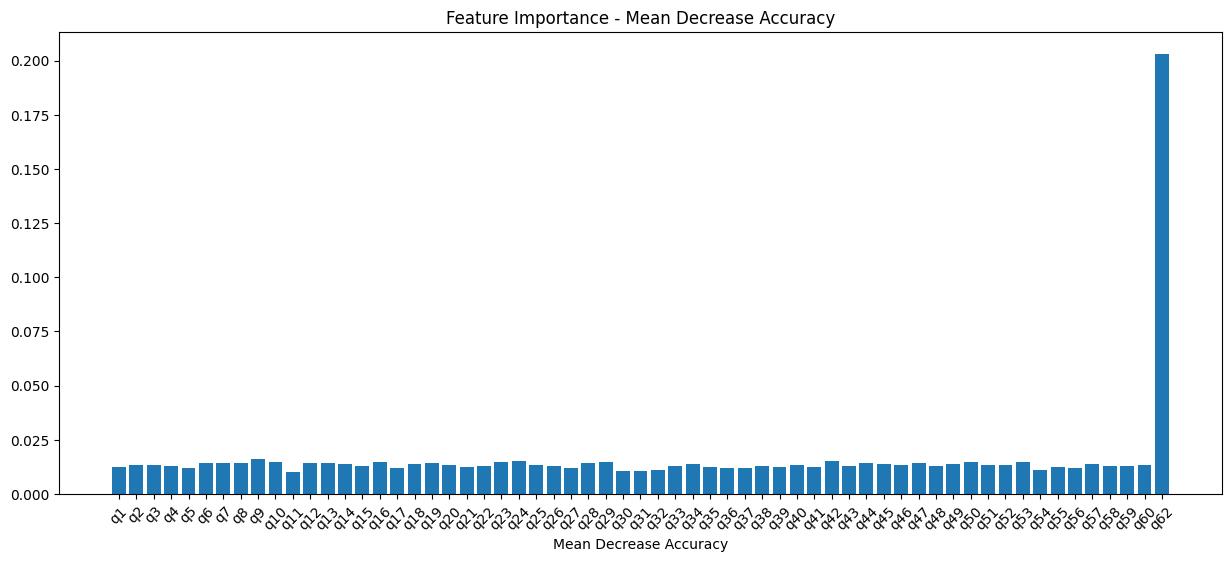

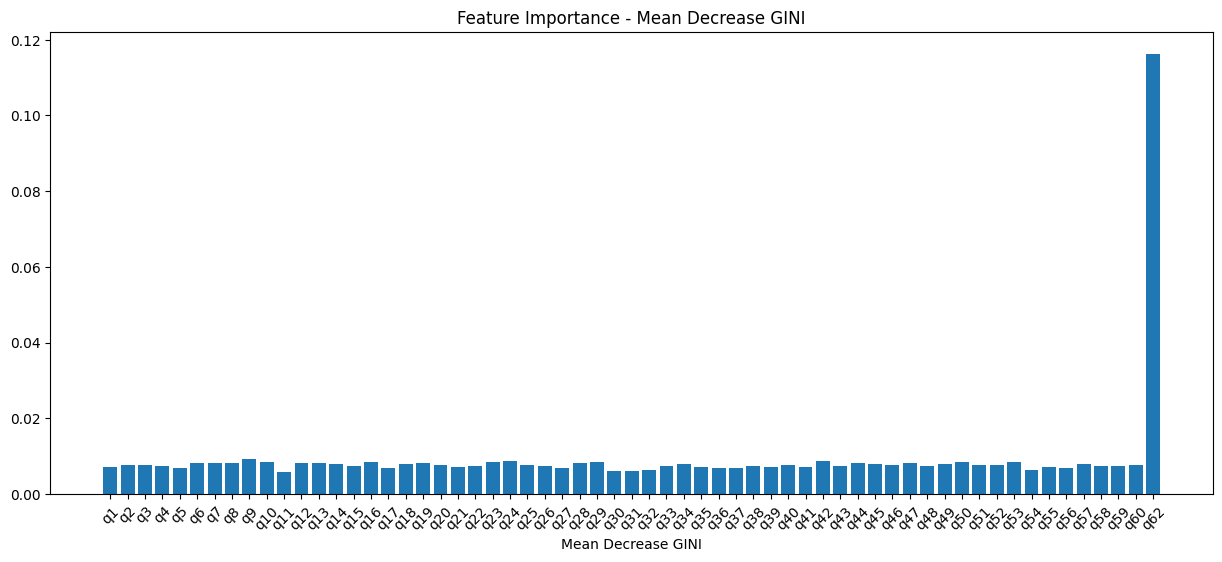

In [ ]:
plt.figure(figsize=(15, 6))
plt.bar(X.columns, mean_decrease_accuracy, width=0.8)
plt.xticks(rotation=45)
plt.xlabel('Mean Decrease Accuracy')
plt.title('Feature Importance - Mean Decrease Accuracy')
plt.show()

plt.figure(figsize=(15, 6))
plt.bar(X.columns, gini_importance, width=0.8)
plt.xticks(rotation=45)
plt.xlabel('Mean Decrease GINI')
plt.title('Feature Importance - Mean Decrease GINI')
plt.show()

In [ ]:
pca = PCA(n_components=0.95)
X_pca = pca.fit(X).transform(X)

In [ ]:
pca.explained_variance_

array([0.7977953 , 0.75529503, 0.50367134, 0.40209072, 0.29831894,
       0.28422408, 0.26745856, 0.25074633, 0.23563483, 0.22861225,
       0.22018018, 0.21987145, 0.21234581, 0.20851855, 0.20533423,
       0.20101691, 0.19829499, 0.19239625, 0.18956018, 0.1874953 ,
       0.18517482, 0.1809486 , 0.180064  , 0.17899545, 0.17472696,
       0.17255771, 0.17125035, 0.1692643 , 0.16726251, 0.16499129,
       0.161073  , 0.16005705, 0.15817521, 0.15382568, 0.15100993,
       0.14906727])

In [ ]:
pca.explained_variance_ratio_

array([0.07907917, 0.07534068, 0.04430958, 0.0356829 , 0.02745785,
       0.02293742, 0.02194848, 0.02038629, 0.01987346, 0.01884104,
       0.01782131, 0.01682197, 0.01633998, 0.01617121, 0.01568724,
       0.01528693, 0.01507533, 0.01493492, 0.01464667, 0.01455632,
       0.01431686, 0.014262  , 0.0140107 , 0.01377749, 0.01372212,
       0.01354863, 0.01332702, 0.01327034, 0.01311322, 0.01304021,
       0.0128583 , 0.01271487, 0.01258817, 0.01250881, 0.01235247,
       0.01232656, 0.01222505, 0.01216332, 0.0119607 , 0.01187478,
       0.01174153, 0.01161561, 0.01136601, 0.01134186, 0.01120724,
       0.01111605, 0.01103583, 0.01087355, 0.01059148, 0.01055678,
       0.01048142, 0.01040761, 0.01019935, 0.01006492, 0.00993562,
       0.00958778])

Text(0, 0.5, 'cumulative explained variance')

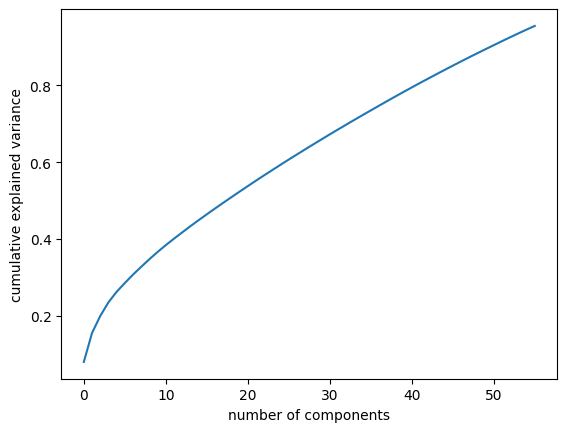

In [ ]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

In [ ]:
pca.n_components_
n_pcs= pca.n_components_ # get number of component
# get the index of the most important feature on EACH component
most_important = np.abs(pca.components_).argmax(axis=1)
initial_feature_names = X.columns
# get the most important feature names
most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]
final_columns = []
PCA_variance = []
for i, (n, var) in enumerate(zip(most_important_names,pca.explained_variance_ratio_)):
    print('Component {} : {:.4f} -> {}'.format(i+1,var,n))
    if n not in final_columns:
      final_columns.append(n)
      PCA_variance.append(var)

Component 1 : 0.0791 -> q62
Component 2 : 0.0753 -> q59
Component 3 : 0.0443 -> q62
Component 4 : 0.0357 -> q62
Component 5 : 0.0275 -> q46
Component 6 : 0.0229 -> q28
Component 7 : 0.0219 -> q7
Component 8 : 0.0204 -> q48
Component 9 : 0.0199 -> q24
Component 10 : 0.0188 -> q23
Component 11 : 0.0178 -> q60
Component 12 : 0.0168 -> q34
Component 13 : 0.0163 -> q10
Component 14 : 0.0162 -> q8
Component 15 : 0.0157 -> q10
Component 16 : 0.0153 -> q57
Component 17 : 0.0151 -> q60
Component 18 : 0.0149 -> q34
Component 19 : 0.0146 -> q58
Component 20 : 0.0146 -> q51
Component 21 : 0.0143 -> q10
Component 22 : 0.0143 -> q4
Component 23 : 0.0140 -> q24
Component 24 : 0.0138 -> q50
Component 25 : 0.0137 -> q57
Component 26 : 0.0135 -> q46
Component 27 : 0.0133 -> q28
Component 28 : 0.0133 -> q19
Component 29 : 0.0131 -> q16
Component 30 : 0.0130 -> q8
Component 31 : 0.0129 -> q46
Component 32 : 0.0127 -> q38
Component 33 : 0.0126 -> q4
Component 34 : 0.0125 -> q40
Component 35 : 0.0124 -> q18

<ipython-input-70-7166725f1e66>:5: UserWarning:

FixedFormatter should only be used together with FixedLocator



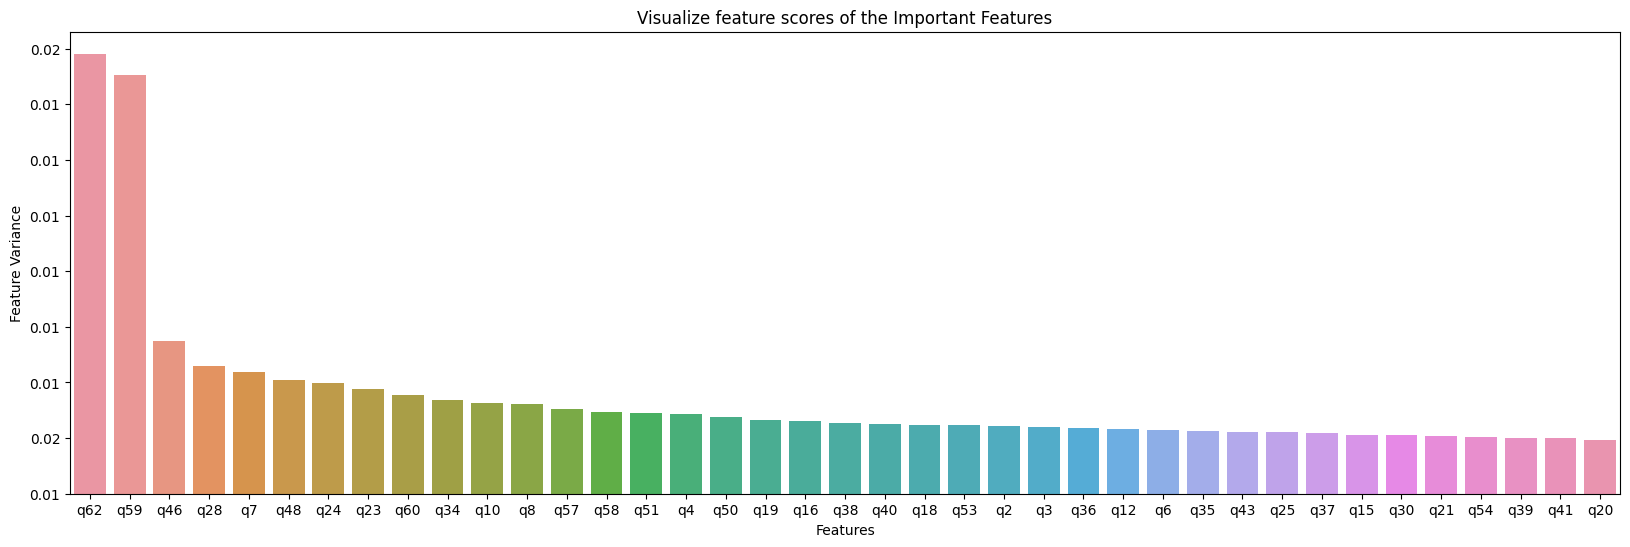

In [ ]:
PCA_imp_features = pd.DataFrame({'Feature': final_columns, 'Variance': PCA_variance})
f, ax = plt.subplots(figsize=(20, 6))
ax = sns.barplot(x=PCA_imp_features['Feature'], y=PCA_imp_features['Variance'], data=PCA_imp_features)
ax.set_title("Visualize feature scores of the Important Features")
ax.set_yticklabels(round(important_features['Importance'], 2))
ax.set_xlabel("Features")
ax.set_ylabel("Feature Variance")
plt.show()

Creating new train test split after PCA

In [ ]:
final_columns = set(final_columns)
X = X[list(final_columns)]
duplicate_cols = X.columns[X.columns.duplicated()]
X.drop(columns=duplicate_cols, inplace=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=47)

<ipython-input-31-fa82e20ff6bc>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



# SVM

Classification Report: 

              precision    recall  f1-score   support

           1       0.86      0.79      0.82     14762
           2       0.52      0.80      0.63      4995
           3       0.52      0.39      0.44      5704

    accuracy                           0.70     25461
   macro avg       0.63      0.66      0.63     25461
weighted avg       0.72      0.70      0.70     25461


Confusion Matrix:
[[11634  1545  1583]
 [  554  3977   464]
 [ 1375  2118  2211]]

Accuracy: 0.6999725069714465


<Axes: >

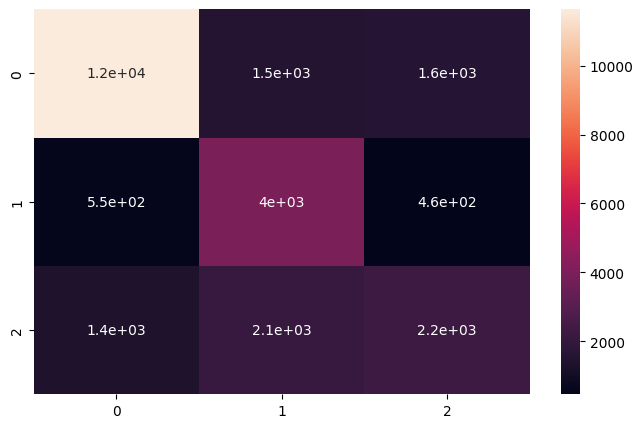

In [ ]:
svc=SVC()
svc.fit(X_train,y_train)
y_pred=svc.predict(X_test)
print("Classification Report: \n")
print(classification_report(y_test, y_pred), end="\n")
print(f'\nConfusion Matrix:\n{confusion_matrix(y_test, y_pred)}')
print(f'\nAccuracy: {accuracy_score(y_test, y_pred)}')
add_to_results('SVC', accuracy_score(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (8,5))
sns.heatmap(cm, annot=True)

# ANN (Multilayer perceptron)

Classification Report: 

              precision    recall  f1-score   support

           1       0.84      0.81      0.82     14762
           2       0.52      0.79      0.63      4995
           3       0.53      0.33      0.41      5704

    accuracy                           0.70     25461
   macro avg       0.63      0.64      0.62     25461
weighted avg       0.71      0.70      0.69     25461


Confusion Matrix:
[[11937  1527  1298]
 [  618  3965   412]
 [ 1708  2106  1890]]

Accuracy: 0.6987942343191548


<Axes: >

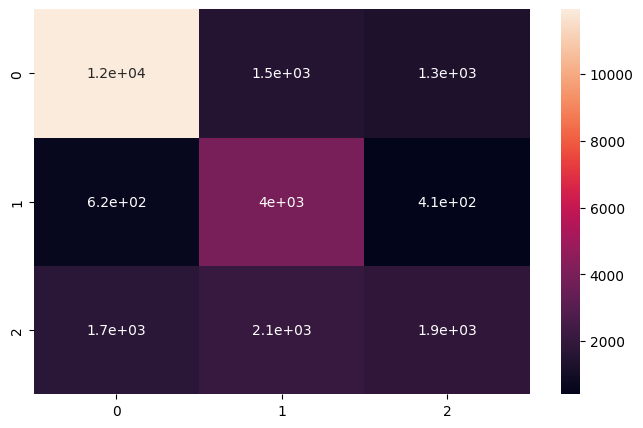

In [ ]:
mlp = MLPClassifier(hidden_layer_sizes=(10, 10), max_iter=1000, random_state=47)
mlp.fit(X_train, y_train)
y_pred = mlp.predict(X_test)
print("Classification Report: \n")
print(classification_report(y_test, y_pred), end="\n")
print(f'\nConfusion Matrix:\n{confusion_matrix(y_test, y_pred)}')
print(f'\nAccuracy: {accuracy_score(y_test, y_pred)}')
add_to_results('ANN', accuracy_score(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (8,5))
sns.heatmap(cm, annot=True)

# KNN

Is it possible to establish a relation between an employees attitude to their job and their resulting performance, given that this performance can only be averaged as such questionnaires are confidential?

To answer this question, we will evaluate job performance separately and determine if a person has performed poorly or well in their job. We will then consider their responses to behavioral questions to establish contribution to this factor - if just behavioral questions can be used to accurately predict performance, we say behavioral questions play a significant role. If accuracy is moderate, we can say there is some relation between attitude and job performance. If the accuracy is poor, we can say there is no relation between attitude and performance.

In [ ]:
acc_scores = []
for i in range(2,20):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    print(f"For n_neighbors = {i}: Accuracy Score: {accuracy_score(y_test, y_pred)}")
    acc_scores.append(accuracy_score(y_test, y_pred))
print(f'Best n_neighbors = {acc_scores.index(max(acc_scores))+2} : Accuracy Score: {max(acc_scores)}')

For n_neighbors = 2: Accuracy Score: 0.6071638977259338
For n_neighbors = 3: Accuracy Score: 0.6110129217234201
For n_neighbors = 4: Accuracy Score: 0.6227170967361848
For n_neighbors = 5: Accuracy Score: 0.6218137543694278
For n_neighbors = 6: Accuracy Score: 0.6260948116727544
For n_neighbors = 7: Accuracy Score: 0.6293939750991713
For n_neighbors = 8: Accuracy Score: 0.630965005302227
For n_neighbors = 9: Accuracy Score: 0.6324574839951298
For n_neighbors = 10: Accuracy Score: 0.6374455048898315
For n_neighbors = 11: Accuracy Score: 0.6380739169710538
For n_neighbors = 12: Accuracy Score: 0.6376811594202898
For n_neighbors = 13: Accuracy Score: 0.6390165350928871
For n_neighbors = 14: Accuracy Score: 0.6374062291347551
For n_neighbors = 15: Accuracy Score: 0.6373669533796787
For n_neighbors = 16: Accuracy Score: 0.6392521896233455
For n_neighbors = 17: Accuracy Score: 0.6395663956639567
For n_neighbors = 18: Accuracy Score: 0.6398413259494914
For n_neighbors = 19: Accuracy Score: 0.

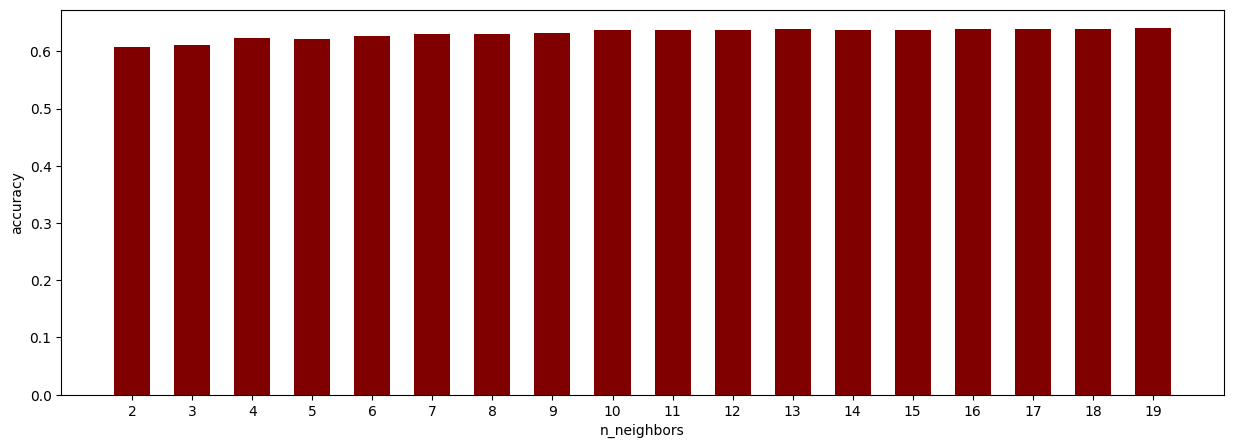

In [ ]:
# plot class labels histogram for df1
fig = plt.figure(figsize = (15, 5))
# creating the bar plot
plt.bar(list(range(2, 20)),acc_scores, color ='maroon', width = 0.6)
plt.ylabel("accuracy")
plt.xlabel("n_neighbors")
plt.xticks(list(range(2, 20)))
plt.show()

Classification Report for df1 features: 

              precision    recall  f1-score   support

           1       0.70      0.87      0.78     14762
           2       0.49      0.34      0.40      4995
           3       0.47      0.31      0.37      5704

    accuracy                           0.64     25461
   macro avg       0.56      0.51      0.52     25461
weighted avg       0.61      0.64      0.61     25461


Confusion Matrix:
[[12846   655  1261]
 [ 2539  1702   754]
 [ 2845  1089  1770]]

Accuracy: 0.6409017713365539


<Axes: >

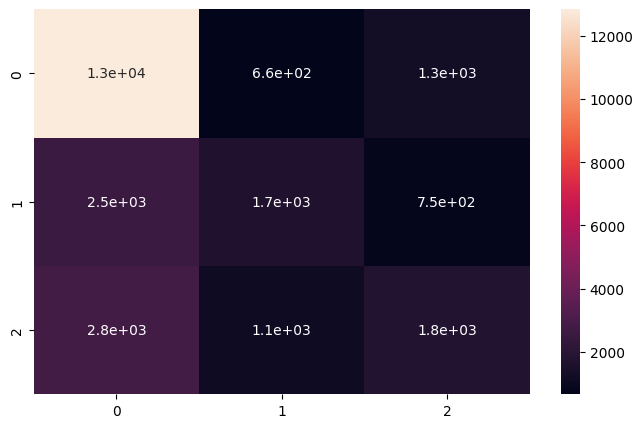

In [ ]:
knn_model = KNeighborsClassifier(n_neighbors=acc_scores.index(max(acc_scores))+2)
knn_model.fit(X_train, y_train)
y_pred = knn_model.predict(X_test)

print("Classification Report for df1 features: \n")
print(classification_report(y_test, y_pred), end="\n")
print(f'\nConfusion Matrix:\n{confusion_matrix(y_test, y_pred)}')
print(f'\nAccuracy: {accuracy_score(y_test, y_pred)}')
add_to_results('KNN', accuracy_score(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (8,5))
sns.heatmap(cm, annot=True)

# NB

Classification Report for df1 features: 

              precision    recall  f1-score   support

           1       0.73      0.80      0.77     14762
           2       0.55      0.40      0.46      4995
           3       0.44      0.43      0.44      5704

    accuracy                           0.64     25461
   macro avg       0.57      0.55      0.56     25461
weighted avg       0.63      0.64      0.63     25461


Confusion Matrix:
[[11862   580  2320]
 [ 2166  2007   822]
 [ 2147  1082  2475]]

Accuracy: 0.6419229409685401


<Axes: >

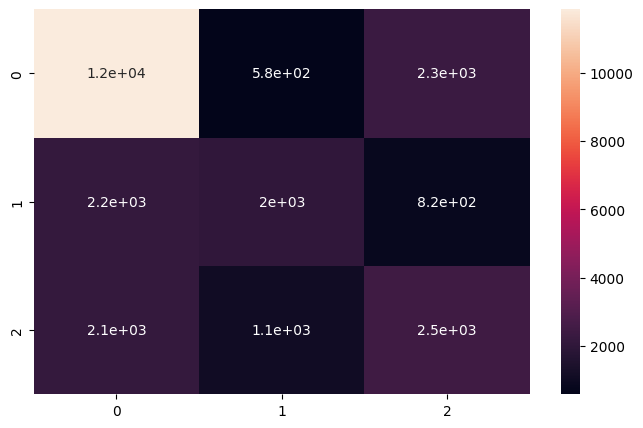

In [ ]:

GNB = GaussianNB()
GNB.fit(X_train, y_train)
y_pred = GNB.predict(X_test)

print("Classification Report for df1 features: \n")
print(classification_report(y_test, y_pred), end="\n")
print(f'\nConfusion Matrix:\n{confusion_matrix(y_test, y_pred)}')
print(f'\nAccuracy: {accuracy_score(y_test, y_pred)}')

add_to_results('GNB', accuracy_score(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (8,5))
sns.heatmap(cm, annot=True)

Classification Report for df1 features: 

              precision    recall  f1-score   support

           1       0.59      0.97      0.74     14762
           2       0.00      0.00      0.00      4995
           3       0.52      0.12      0.19      5704

    accuracy                           0.59     25461
   macro avg       0.37      0.36      0.31     25461
weighted avg       0.46      0.59      0.47     25461


Confusion Matrix:
[[14360     0   402]
 [ 4768     0   227]
 [ 5026     0   678]]

Accuracy: 0.590628804838773


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



<Axes: >

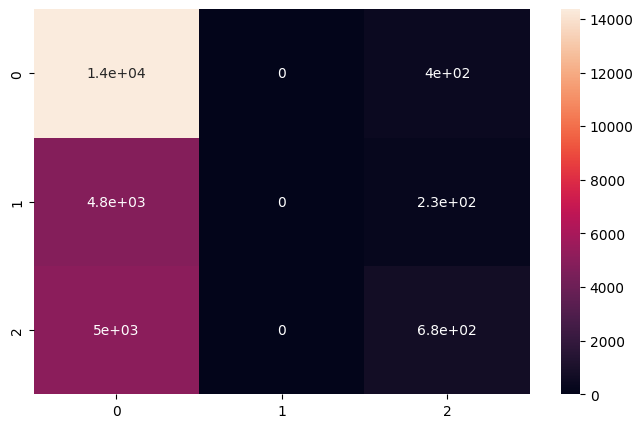

In [ ]:
MNB = MultinomialNB()
MNB.fit(X_train, y_train)
y_pred = MNB.predict(X_test)

print("Classification Report for df1 features: \n")
print(classification_report(y_test, y_pred), end="\n")
print(f'\nConfusion Matrix:\n{confusion_matrix(y_test, y_pred)}')
print(f'\nAccuracy: {accuracy_score(y_test, y_pred)}')

add_to_results('MNB', accuracy_score(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (8,5))
sns.heatmap(cm, annot=True)

# Logistic Regression

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression




Classification Report for df1 features: 
               precision    recall  f1-score   support

           1       0.66      0.86      0.75     14762
           2       0.58      0.06      0.11      4995
           3       0.48      0.47      0.48      5704

    accuracy                           0.62     25461
   macro avg       0.57      0.46      0.44     25461
weighted avg       0.60      0.62      0.56     25461



<Axes: >

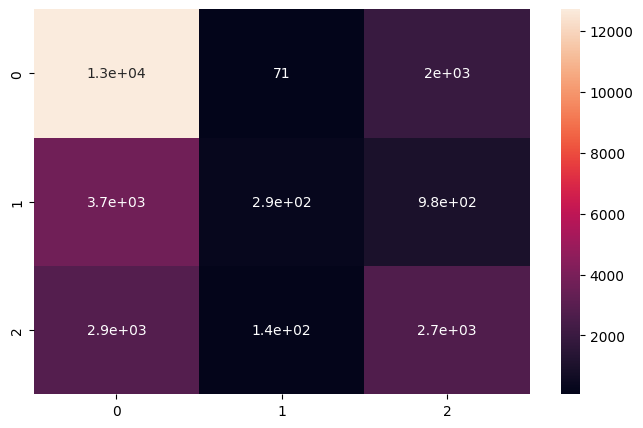

In [ ]:
lr1 = LogisticRegression()
lr1.fit(X_train, y_train)
y_pred = lr1.predict(X_test)
lr_cfreport = classification_report(y_test, y_pred)
print("\nClassification Report for df1 features: \n", lr_cfreport)
add_to_results('LR', accuracy_score(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (8,5))
sns.heatmap(cm, annot=True)

# ADABoost


Classification Report for df1 features: 
               precision    recall  f1-score   support

           1       0.83      0.81      0.82     14762
           2       0.52      0.78      0.62      4995
           3       0.52      0.33      0.40      5704

    accuracy                           0.70     25461
   macro avg       0.63      0.64      0.62     25461
weighted avg       0.70      0.70      0.69     25461



<Axes: >

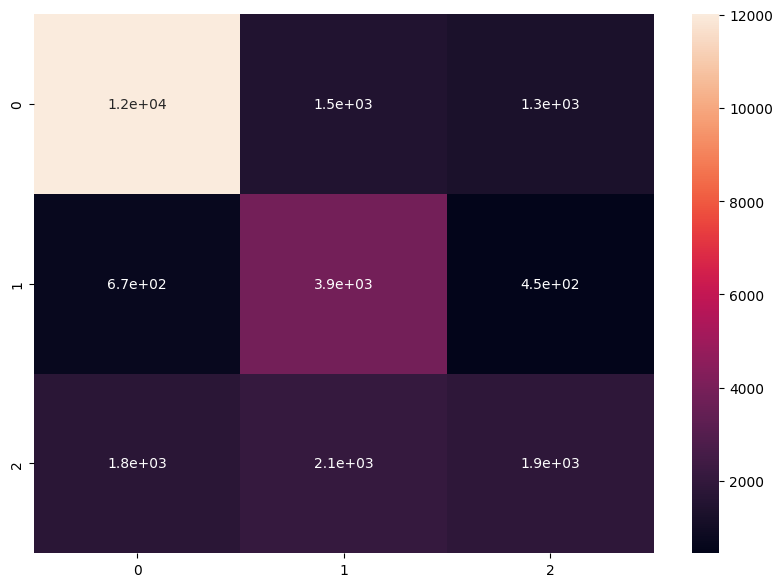

In [ ]:
from sklearn import metrics
adaClf1 = AdaBoostClassifier(n_estimators=100, random_state=47)
adaClf1.fit(X_train, y_train)
y_pred = adaClf1.predict(X_test)
ada_cfreport = classification_report(y_test, y_pred)
add_to_results('ADABoost', accuracy_score(y_test, y_pred))
print("\nClassification Report for df1 features: \n", ada_cfreport)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (10,7))
sns.heatmap(cm, annot=True)

# Deep Neural Network

In [ ]:
X_train.shape

(59407, 39)

In [ ]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
inp_layer = Input(shape = X_train.shape[1], )
dense = Dense(X_train.shape[1]*4, activation = 'relu')(inp_layer)
dense1 = Dense(X_train.shape[1]*2, activation = 'relu')(dense)
out_layer = Dense(1, activation= "sigmoid")(dense1)
model_func = Model(inp_layer, out_layer)
model_func.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy",f1_m,precision_m, recall_m])

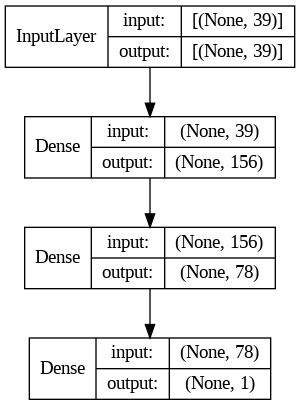

In [ ]:
from keras.utils import plot_model

plot_model(model_func, to_file='model_plot.png', show_shapes=True, show_layer_names=False)

In [ ]:
history = model_func.fit(X_train,
y_train,
epochs=5,
batch_size=16,
validation_data=(X_test, y_test))

Epoch 1/5
3713/3713 [==============================] - 13s 3ms/step - loss: -8453090.0000 - accuracy: 0.5822 - f1_m: 1.0000 - precision_m: 21545.9199 - recall_m: 0.9998 - val_loss: -30135880.0000 - val_accuracy: 0.5798 - val_f1_m: 1.0000 - val_precision_m: 1.0000 - val_recall_m: 1.0000
Epoch 2/5
3713/3713 [==============================] - 12s 3ms/step - loss: -87375736.0000 - accuracy: 0.5824 - f1_m: 1.0000 - precision_m: 1.0000 - recall_m: 1.0000 - val_loss: -166051440.0000 - val_accuracy: 0.5798 - val_f1_m: 1.0000 - val_precision_m: 1.0000 - val_recall_m: 1.0000
Epoch 3/5
3713/3713 [==============================] - 12s 3ms/step - loss: -294646848.0000 - accuracy: 0.5824 - f1_m: 1.0000 - precision_m: 1.0000 - recall_m: 1.0000 - val_loss: -452077760.0000 - val_accuracy: 0.5798 - val_f1_m: 1.0000 - val_precision_m: 1.0000 - val_recall_m: 1.0000
Epoch 4/5
3713/3713 [==============================] - 12s 3ms/step - loss: -670352064.0000 - accuracy: 0.5824 - f1_m: 1.0000 - precision_m: 1

796/796 [==============================] - 1s 1ms/step


<Axes: >

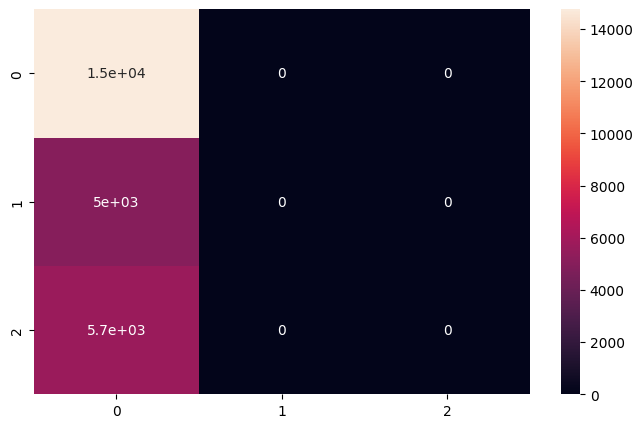

In [ ]:
loss, accuracy, f1_score, precision, recall = model_func.evaluate(X_test, y_test, verbose=0)
knn_y_pred = model_func.predict(X_test)
add_to_results("DNN", accuracy)
cm = confusion_matrix(y_test, knn_y_pred)
plt.figure(figsize = (8,5))
sns.heatmap(cm,annot=True)

In [ ]:
all_models = {}
acc = []
m_name = []
for i in results:
  acc.append(i['Accuracy_Score'])
  m_name.append(i['name'])
all_models['Models'] = m_name
all_models['Accuracy_Score'] = acc
all_models_df = pd.DataFrame.from_dict(all_models)

from tabulate import tabulate
headers=["Models", "Accuracy Score"]
print(tabulate(np.array(all_models_df, dtype=object),headers,tablefmt='heavy_grid'))

┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Models            ┃   Accuracy Score ┃
┣━━━━━━━━━━━━━━━━━━━╋━━━━━━━━━━━━━━━━━━┫
┃ DecisionTree C5.0 ┃         0.697184 ┃
┣━━━━━━━━━━━━━━━━━━━╋━━━━━━━━━━━━━━━━━━┫
┃ Random Forest     ┃         0.697184 ┃
┣━━━━━━━━━━━━━━━━━━━╋━━━━━━━━━━━━━━━━━━┫
┃ SVC               ┃         0.699973 ┃
┣━━━━━━━━━━━━━━━━━━━╋━━━━━━━━━━━━━━━━━━┫
┃ ANN               ┃         0.698794 ┃
┣━━━━━━━━━━━━━━━━━━━╋━━━━━━━━━━━━━━━━━━┫
┃ KNN               ┃         0.640902 ┃
┣━━━━━━━━━━━━━━━━━━━╋━━━━━━━━━━━━━━━━━━┫
┃ GNB               ┃         0.641923 ┃
┣━━━━━━━━━━━━━━━━━━━╋━━━━━━━━━━━━━━━━━━┫
┃ MNB               ┃         0.584698 ┃
┣━━━━━━━━━━━━━━━━━━━╋━━━━━━━━━━━━━━━━━━┫
┃ LR                ┃         0.616983 ┃
┣━━━━━━━━━━━━━━━━━━━╋━━━━━━━━━━━━━━━━━━┫
┃ ADABoost          ┃         0.697616 ┃
┗━━━━━━━━━━━━━━━━━━━┻━━━━━━━━━━━━━━━━━━┛


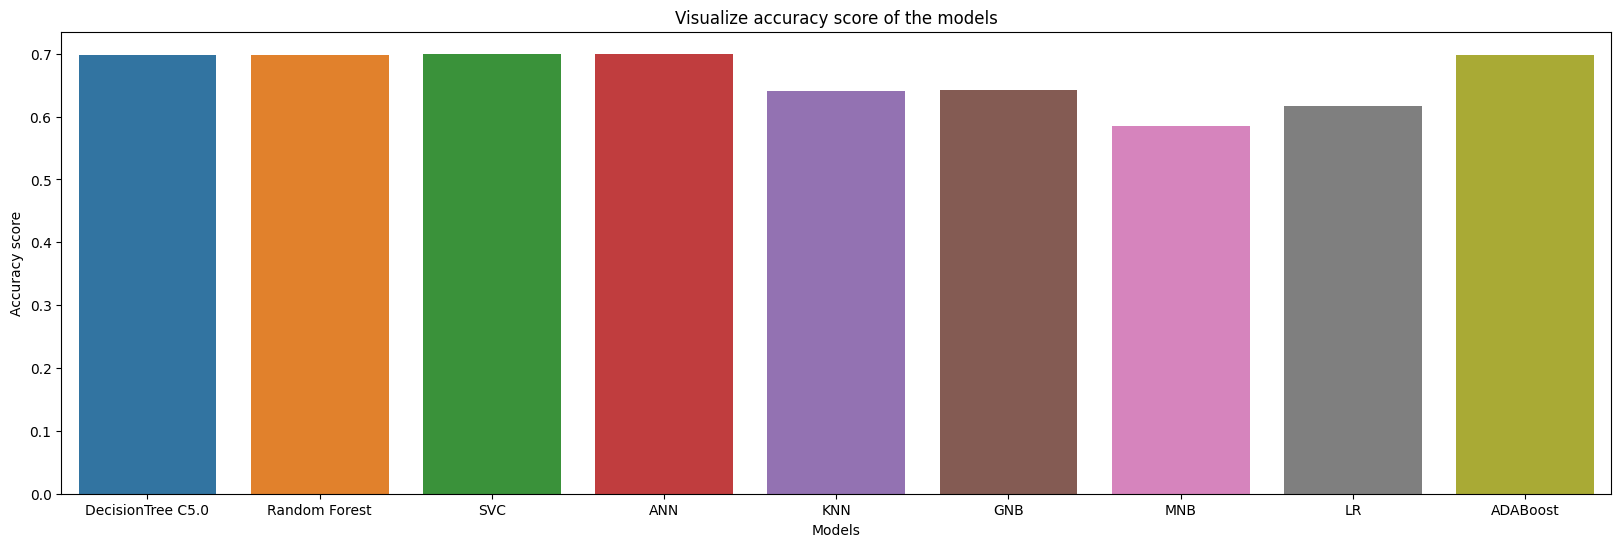

In [ ]:
f, ax = plt.subplots(figsize=(20, 6))
ax = sns.barplot(x=all_models_df['Models'], y=all_models_df['Accuracy_Score'], data=all_models_df)
ax.set_title("Visualize accuracy score of the models")
ax.set_xlabel("Models")
ax.set_ylabel("Accuracy score")
plt.show()